# Qaintellect variational quantum thermalizer (VQT) example

In this example, we implement the VQT algorithm by Verdon et al. to approximate a thermal state using a quantum circuit.

Reference:
- G. Verdon, J. Marks, S. Nanda, S. Leichenauer, J. Hidary: "Quantum Hamiltonian-based models and the variational quantum thermalizer algorithm", [arXiv:1910.02071](https://arxiv.org/abs/1910.02071) (2019)

In [1]:
include("../src/Qaintellect.jl")
using .Qaintellect
using LinearAlgebra
using SparseArrays
using Flux
using IterTools: ncycle

In [2]:
# visualization
using Plots
using LaTeXStrings

In [3]:
using Random
Random.seed!(142);

## Physical model: Hamiltonian and thermal state

In [4]:
"""
Construct adjacency map for a cartesian Nx × Ny lattice.
"""
function lattice_adjacency_map(Nx::Integer, Ny::Integer; pbc=true)
    L = Nx * Ny
    adjacency = zeros(Int, (L, L))
    for j in 0:Ny-1
        j_next = (j+1) % Ny
        for i in 0:Nx-1
            i_next = (i+1) % Nx
            # nearest neighbors
            if (pbc || i_next > 0) adjacency[j*Nx + i + 1, j*Nx + i_next + 1] = 1; end
            if (pbc || j_next > 0) adjacency[j*Nx + i + 1, j_next*Nx + i + 1] = 1; end
        end
    end
    adjacency = adjacency + transpose(adjacency)
    # only 0 or 1 entries
    return (adjacency .≠ 0)
end

lattice_adjacency_map

In [5]:
adj = lattice_adjacency_map(2, 3; pbc=false)

6×6 BitArray{2}:
 0  1  1  0  0  0
 1  0  0  1  0  0
 1  0  0  1  1  0
 0  1  1  0  0  1
 0  0  1  0  0  1
 0  0  0  1  1  0

In [6]:
# number of neighbors
sum(adj, dims=1)

1×6 Array{Int64,2}:
 2  2  3  3  2  2

In [7]:
# number of lattice sites
L = size(adj, 1)

6

In [8]:
"""
Construct horizontal adjacency map for a cartesian Nx × Ny lattice.
"""
function lattice_adjacency_map_horz(Nx::Integer, Ny::Integer; pbc=true)
    L = Nx * Ny
    adjacency = zeros(Int, (L, L))
    for j in 0:Ny-1
        for i in 0:Nx-1
            i_next = (i+1) % Nx
            # nearest neighbors along horizontal direction
            if (pbc || i_next > 0) adjacency[j*Nx + i + 1, j*Nx + i_next + 1] = 1; end
        end
    end
    adjacency = adjacency + transpose(adjacency)
    # only 0 or 1 entries
    return (adjacency .≠ 0)
end

"""
Construct vertical adjacency map for a cartesian Nx × Ny lattice.
"""
function lattice_adjacency_map_vert(Nx::Integer, Ny::Integer; pbc=true)
    L = Nx * Ny
    adjacency = zeros(Int, (L, L))
    for j in 0:Ny-1
        j_next = (j+1) % Ny
        for i in 0:Nx-1
            # nearest neighbors along vertical direction
            if (pbc || j_next > 0) adjacency[j*Nx + i + 1, j_next*Nx + i + 1] = 1; end
        end
    end
    adjacency = adjacency + transpose(adjacency)
    # only 0 or 1 entries
    return (adjacency .≠ 0)
end

lattice_adjacency_map_vert

In [9]:
adj_horz = lattice_adjacency_map_horz(2, 3; pbc=false)

6×6 BitArray{2}:
 0  1  0  0  0  0
 1  0  0  0  0  0
 0  0  0  1  0  0
 0  0  1  0  0  0
 0  0  0  0  0  1
 0  0  0  0  1  0

In [10]:
adj_vert = lattice_adjacency_map_vert(2, 3; pbc=false)

6×6 BitArray{2}:
 0  0  1  0  0  0
 0  0  0  1  0  0
 1  0  0  0  1  0
 0  1  0  0  0  1
 0  0  1  0  0  0
 0  0  0  1  0  0

In [11]:
# consistency check (results should be zero)
@show(norm(adj_horz + adj_vert - adj))
@show(norm(adj_horz .* adj_vert))

norm((adj_horz + adj_vert) - adj) = 0.0
norm(adj_horz .* adj_vert) = 0.0


0.0

In [12]:
"""
Identity map as sparse matrix with real-valued entries.
"""
sparse_identity(n) = sparse(1.0*I, n, n)

sparse_identity

In [13]:
"""
Construct a Heisenberg-type Hamiltonian as sparse matrix using site-dependent interation strength, with nearest-neighbor interactions according to adjacency.
"""
function construct_hamiltonian(J::Array{<:Real,3})
    L = size(J, 3)
    @assert(size(J) == (3, L, L))

    # spin operators (Pauli matrices divided by 2)
    sigma12 = (0.5*sparse([0.  1.; 1.  0.]),
               0.5*sparse([0. -im; im  0.]),
               0.5*sparse([1.  0.; 0. -1.]))

    H = spzeros(Float64, 2^L, 2^L)

    # interaction terms
    for i in 1:L
        for j in i+1:L
            for k in 1:3
                # considering only entries in J for i < j
                if J[k, i, j] ≠ 0
                    H -= J[k, i, j] * real(kron(sparse_identity(2^(L-j)), sigma12[k], sparse_identity(2^(j-i-1)), sigma12[k], sparse_identity(2^(i-1))))
                end
            end
        end
    end

    return H
end

construct_hamiltonian

In [14]:
# model parameters
β = 2.6
Jx = 1.0
Jy = 0.6

0.6

In [15]:
# construct Hamiltonian
J = Jx * reshape(kron(adj_horz, [1, 1, 1]), (3, L, L)) + Jy * reshape(kron(adj_vert, [1, 1, 1]), (3, L, L))
H = construct_hamiltonian(J)
@assert(H ≈ H')
size(H)

(64, 64)

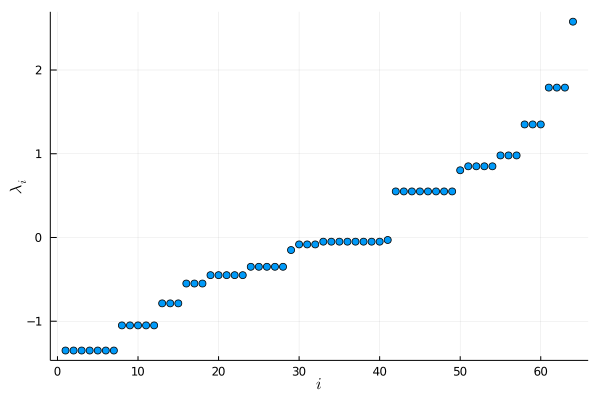

In [16]:
# show eigenvalues
scatter(eigvals(Matrix(H)), xlabel=L"i", ylabel=L"\lambda_i", legend=false)

In [17]:
"""
Compute `-log(Z)`, with `Z` the partition function.
"""
thermal_logZ(βH::AbstractMatrix) = -log(tr(exp(-Matrix(βH))))

thermal_logZ

In [18]:
thermal_logZ(β*H)

-5.974568533204814

In [19]:
"""
Compute the thermal state `exp(-βH) / Z`, with `Z` the partition function.
"""
function thermal_state(βH::AbstractMatrix)
    σ = exp(-Matrix(βH))
    return σ / tr(σ)
end

thermal_state

In [20]:
σtherm = thermal_state(β*H)
typeof(σtherm)

Array{Float64,2}

In [21]:
# consistency check
tr(σtherm) - 1

-5.551115123125783e-16

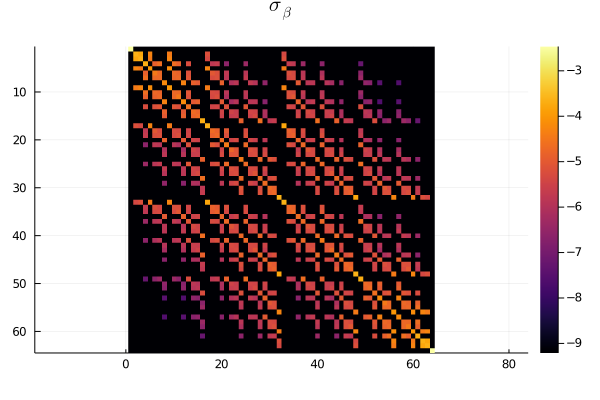

In [22]:
heatmap(log.(max.(σtherm, 1e-4)), title=L"\sigma_{\beta}", yflip=true, aspect_ratio=:equal)

## Parameterized quantum circuit and latent density matrix

In [23]:
"""
Construct a parametrized quantum layer consisting of single and two qubit rotation gates.
"""
function construct_parameterized_layer(L::Integer, istart::Integer)

    # TODO: take 2D adjacency into account? periodic boundary conditions?

    # local gates
    Uloc = [Moment([circuit_gate(i, RotationGate(0.05*π*randn(3))) for i in 1:L])]

    # interaction gates
    Uint = [
        Moment([two_qubit_circuit_gate(i, i+1, EntanglementXXGate(0.05π*randn())) for i in istart:2:L-1]),
        Moment([two_qubit_circuit_gate(i, i+1, EntanglementYYGate(0.05π*randn())) for i in istart:2:L-1]),
        Moment([two_qubit_circuit_gate(i, i+1, EntanglementZZGate(0.05π*randn())) for i in istart:2:L-1])]

    return vcat(Uloc, Uint)
end

construct_parameterized_layer

In [24]:
# parameterized quantum circuit gate chain
cgc = vcat(construct_parameterized_layer(L, 1), construct_parameterized_layer(L, 2), construct_parameterized_layer(L, 1));

In [25]:
# use Hamiltonian as measurement operator; note that H gets converted to a complex matrix here
Hmeas = MeasurementOperator(H, Tuple(1:L));

In [26]:
# parameterized quantum circuit
circ = Circuit{L}(cgc, [Hmeas])


    6 —[Rθ]———□—————□—————□————[Rθ]————————————————————[Rθ]———□—————□—————□———
              |     |     |                                   |     |     |   
    5 —[Rθ]———□—————□—————□————[Rθ]———□—————□—————□————[Rθ]———□—————□—————□———
                                      |     |     |                           
    4 —[Rθ]———□—————□—————□————[Rθ]———□—————□—————□————[Rθ]———□—————□—————□———
              |     |     |                                   |     |     |   
    3 —[Rθ]———□—————□—————□————[Rθ]———□—————□—————□————[Rθ]———□—————□—————□———
                                      |     |     |                           
    2 —[Rθ]———□—————□—————□————[Rθ]———□—————□—————□————[Rθ]———□—————□—————□———
              |     |     |                                   |     |     |   
    1 —[Rθ]———□—————□—————□————[Rθ]——————————————[Rθ]—————————□—————□—————□———


In [27]:
# use representation of density matrix in terms of Pauli matrices; cos(θ) is Bloch vector coefficient of Pauli-Z for each qubit
latent_density(θlist) = DensityMatrix(kron([[1, 0, 0, cos(θ)] for θ in θlist]...), length(θlist))

latent_density (generic function with 1 method)

In [28]:
# example
latent_density([π/3, 3π/8])

DensityMatrix([1.0, 0.0, 0.0, 0.38268343236508984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5000000000000001, 0.0, 0.0, 0.19134171618254497], 2)

## Target ("loss") function and distance measures

In [29]:
"""
    xlogx(x::Number)

Compute `x * log(x)`, returning zero if `x` is zero. (Copied from StatsFuns.jl package.)
"""
function xlogx(x::Number)
    result = x * log(x)
    ifelse(iszero(x), zero(result), result)
end

xlogx

In [30]:
"""
    binary_entropy(p::Number)

Compute the binary entropy of `p` (natural logarithm).
"""
binary_entropy(p::Number) = -(xlogx(p) + xlogx(1 - p))

binary_entropy

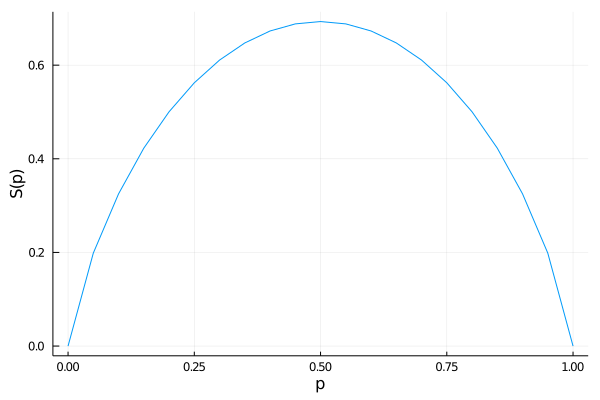

In [31]:
# visualize binary entropy
plot(0:0.05:1, binary_entropy.(0:0.05:1), xlabel="p", ylabel="S(p)", legend=false)

In [32]:
"""
Compute the von Neumann entropy of a density matrix `ρ`.
"""
neumann_entropy(ρ::AbstractMatrix) = -sum(xlogx.(real(eigvals(Matrix(ρ)))))

neumann_entropy

In [33]:
# target function: β tr[ρ H] - S(ρ), with ρ = U ρlatent U†
ftarget(θlist) = β * apply(circ, latent_density(θlist))[1] - sum(binary_entropy.((1 .+ cos.(θlist)) / 2))

ftarget (generic function with 1 method)

In [34]:
# initial random θ parameters, which are to be optimized
θopt = π/2 * (1 .+ 0.5*randn(L))

6-element Array{Float64,1}:
 1.868359801242441
 1.060389067387116
 0.6242057421026134
 1.4731764371932827
 0.8061934487488968
 0.9868069670558753

In [35]:
# example
ftarget(θopt)

-3.454346355247991

In [36]:
# consistency check
neumann_entropy(matrix(apply(cgc, latent_density(θopt)))) - sum(binary_entropy.((1 .+ cos.(θopt)) / 2))

-8.881784197001252e-16

In [37]:
"""
Trace distance to target density matrix `σ`.
"""
trdistance(θlist, σ) = 0.5 * opnorm(matrix(apply(cgc, latent_density(θlist))) - σ, 1)

trdistance

In [38]:
# example
trdistance(θopt, σtherm)

0.19579532341343417

## Perform optimization

In [39]:
# gather parameters from circuit
paras = Flux.params(circ)
# measurement operator (Hamiltonian) not "trainable" here
delete!(paras, circ.meas[1].operator)
# add θ parameters
Flux.params!(paras, θopt)
paras

Params([[-0.032689516897612896, 0.11723480881283915, -0.045725107158529676], [-0.001520505936978918, -0.2860597192812869, -0.14517933263127242], [-0.044905983990877814, 0.13584324485124732, 0.16067012148353474], [0.35345577510743387, 0.1522511129504494, -0.02784330896229452], [0.14938863218235993, -0.10540393806198983, -0.2095642486984505], [0.22021717064502935, -0.036630740017564944, 0.39804581190311705], [-0.10968491520044701], [0.025272938605999738], [-0.23647154235046933], [-0.008800429124181719], [0.13451804982256704], [-0.030642555602742146], [0.014644393047936886], [-0.057949370924255984], [0.1788031093792638], [0.22130813368007962, 0.10181161281624457, 0.349895172414667], [0.05207820405618892, 0.25992990214146633, -0.4411003513588946], [0.17938794853556728, -0.1422455891426142, 0.23752073528613366], [0.1827189357647708, 0.06580117281617619, -0.11518921080548353], [0.1934973944083283, -0.2508076153066435, 0.08224480669615179], [-0.2418979625048874, 0.05148535176720055, -0.136298

In [40]:
# there is not actually any input data for training
data = ncycle([()], 100)

# define optimizer
opt = RMSProp(0.05)

# define evaluation function
evalcb() = println("ftarget(θopt): $(ftarget(θopt)), reference: $(thermal_logZ(β*H)); trdistance(θopt, σtherm): $(trdistance(θopt, σtherm))")

# perform optimization
Flux.train!(() -> ftarget(θopt), paras, data, opt, cb=Flux.throttle(evalcb, 4.0))

ftarget(θopt): -3.964676033383333, reference: -5.974568533204814; trdistance(θopt, σtherm): 0.125259176983164
ftarget(θopt): -4.734470707413451, reference: -5.974568533204814; trdistance(θopt, σtherm): 0.07837206763268144
ftarget(θopt): -4.969826944504824, reference: -5.974568533204814; trdistance(θopt, σtherm): 0.08101769603800625
ftarget(θopt): -5.0240617028220935, reference: -5.974568533204814; trdistance(θopt, σtherm): 0.08394234404923664
ftarget(θopt): -5.026501096140285, reference: -5.974568533204814; trdistance(θopt, σtherm): 0.0874379998914719
ftarget(θopt): -5.04141493804773, reference: -5.974568533204814; trdistance(θopt, σtherm): 0.08957135444840393
ftarget(θopt): -5.063532516524257, reference: -5.974568533204814; trdistance(θopt, σtherm): 0.08455752068671331
ftarget(θopt): -5.0783514704081405, reference: -5.974568533204814; trdistance(θopt, σtherm): 0.09562384116714676
ftarget(θopt): -5.086059338876118, reference: -5.974568533204814; trdistance(θopt, σtherm): 0.094863369514

In [41]:
# seems like the Ansatz is too restricted, or the optimization trapped in a local minimum, to further descrease the distance
trdistance(θopt, σtherm)

0.09601780382278746

In [42]:
# optimized variational density matrix
ρopt = apply(cgc, latent_density(θopt))

DensityMatrix([1.0, 0.20194933046101576, 0.1327001485853629, 0.15698816412941038, 0.2602372159768674, 0.37508937830992695, 0.09613808576279008, 0.05873391444838078, 0.03296851775118595, -0.054302848801540134  …  -0.00048506029171083446, 0.000678552845914761, -7.245146685751832e-5, 0.00041985544635019493, -0.00036210643151393413, 0.00018782159336771392, -0.00028071052867352183, 5.8863984959172256e-5, -7.087429744432987e-6, 1.0583575105136931e-5], 6)

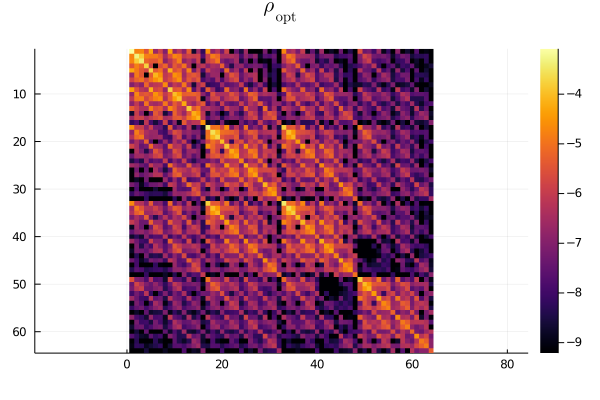

In [43]:
# visualize optimized density matrix
heatmap(log.(max.(real(matrix(ρopt)), 1e-4)), title=L"\rho_{\mathrm{opt}}", yflip=true, aspect_ratio=:equal)